[*********************100%***********************]  1 of 1 completed
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
192/192 - 6s - loss: 0.0185 - 6s/epoch - 29ms/step
Epoch 2/100
192/192 - 2s - loss: 0.0065 - 2s/epoch - 8ms/step
Epoch 3/100
192/192 - 1s - loss: 0.0064 - 1s/epoch - 7ms/step
Epoch 4/100
192/192 - 1s - loss: 0.0059 - 1s/epoch - 7ms/step
Epoch 5/100
192/192 - 1s - loss: 0.0053 - 1s/epoch - 6ms/step
Epoch 6/100
192/192 - 1s - loss: 0.0

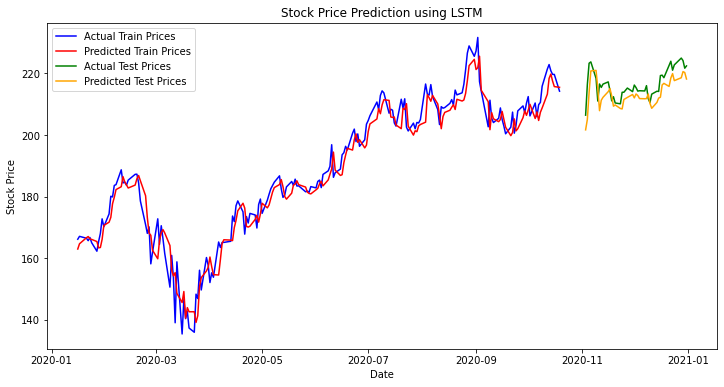

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Step 1: Dataset Collection (Using Microsoft stock data from Yahoo Finance)
ticker = 'MSFT'
start_date = '2020-01-01'
end_date = '2021-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

# Step 2: Data Preprocessing
data['Date'] = pd.to_datetime(data.index)
data = data[['Date', 'Close']]
data.set_index('Date', inplace=True)

# Step 3: Data Preparation
dataset = data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# Step 4: Splitting the Dataset
train_size = int(len(scaled_dataset) * 0.8)
test_size = len(scaled_dataset) - train_size
train_data, test_data = scaled_dataset[0:train_size], scaled_dataset[train_size:]

# Function to create dataset with time steps for LSTM
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 10
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 5: Model Creation (LSTM)
model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Step 6: Model Training
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Step 7: Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform([y_train])
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform([y_test])

train_mse = mean_squared_error(y_train[0], train_predictions[:, 0])
test_mse = mean_squared_error(y_test[0], test_predictions[:, 0])

print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)

# Step 8: Visualization
plt.figure(figsize=(12, 6))
plt.plot(data.index[time_steps:train_size], y_train[0], label='Actual Train Prices', color='blue')
plt.plot(data.index[time_steps:train_size], train_predictions[:, 0], label='Predicted Train Prices', color='red')
plt.plot(data.index[train_size + time_steps:], y_test[0], label='Actual Test Prices', color='green')
plt.plot(data.index[train_size + time_steps:], test_predictions[:, 0], label='Predicted Test Prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()
